Stock Data Analsysis 
--------------------  
[1. Read data from files and load on to the memory. Transform them into suitable format.](#1)  
[2. Computing averages](#2)  
    - avg (closing price of all stocks) over all time period
    - avg (volume) for each stock over.. 
    - avg(close - open price) for each stock over .. 
    - avg(high - low price) for each stock over.. 
[3. The most traded stock each day](#3)
    - create a data structure that stores dates & stock symbols that were most traded on that day to see what company is hot.
[4. Which stock has the greatest descrepance between open price and closing price the day before?](#4)    

<a id='1'></a>
## 1. Read data from files and load on to the memory 
I've pre-downloaded stock time series data(adjusted price) files in `/prices`, which I'll read and load on to the memory. It has following data column for each stock for over 20years. 
- 'timestamp': Date (YYYY-MM-DD)
- 'open': Opening price
- 'high': Highest point price 
- 'low': Lowest point price
- 'close': Closing price
- 'adjusted_close': The closing price as a starting point, but it takes into account factors such as dividends, stock splits and new stock offerings. Represents a more accurate reflection of a stock's value.
- 'volume': trading volume (shares)
- 'dividend_amount': Dividend can come either in the form of cash paid per share or additional shares. If dividend amount is .42, it means it is paid $.42 per share for shareholders as a dividend.
- 'split_coefficient': Stock split, if the company splits its stock 2-for-1, the split cofficient will be .5

In [1]:
import concurrent.futures
import os 

In [2]:
def readfile(filename):
    symbol = filename.split('_')[0]
    rows = []
    try:
        with open('../prices/TIME_SERIES_DAILY_ADJUSTED/'+filename) as f:
            rows = f.read().strip()
            rows = rows.split('\n')
            rows = [line.split(',') for line in rows]
    except Exception as e:
        print('read file error')
    return symbol, rows 

In [3]:
pool = concurrent.futures.ThreadPoolExecutor(max_workers=4)
filenames = [f for f in os.listdir('../prices') if f.endswith(".csv")]

prices = pool.map(readfile, filenames)

In [4]:
prices = dict(list(prices))

In [5]:
# take a look how it looks like 
prices['dax'][:3]

[['timestamp',
  'open',
  'high',
  'low',
  'close',
  'adjusted_close',
  'volume',
  'dividend_amount',
  'split_coefficient'],
 ['2018-04-06',
  '30.3100',
  '30.4900',
  '30.3000',
  '30.3100',
  '30.3100',
  '3485',
  '0.0000',
  '1.0000'],
 ['2018-04-05',
  '30.4100',
  '30.5100',
  '30.3600',
  '30.5100',
  '30.5100',
  '9589',
  '0.0000',
  '1.0000']]

`prices` has 3 layers and it's row-based (dictionary - symbol as key, list - time series data, and list - data for a specific date). I'll turn this into column-based so that it will be easy to calculate statistics on a certain column. It could take a few seconds.

In [6]:
from dateutil.parser import parse 

def transform_columnwise(symbol):
    try:
        column_data = {}
        rows = prices[symbol]
        headers = rows[0]# header 
        for idx, col_name in enumerate(headers):# parse data
            values = [p[idx] for p in rows[1:]]
            if idx == 0:# timestamp type 
                values = [parse(v) for v in values]
            else:# float type 
                values = [float(v) for v in values]
            column_data[col_name] = values
    except Exception as e:
        print(e)
        pass
    return symbol, column_data

In [7]:
pool = concurrent.futures.ProcessPoolExecutor(max_workers=4)
symbols = list(prices.keys())

prices_columnwise = pool.map(transform_columnwise, symbols)

In [8]:
import time
start = time.time()
prices_columnwise = dict(list(prices_columnwise))
print("It took {}secs".format(time.time()-start))

It took 104.07041192054749secs


<a id='2'></a>
## 2. Computing averages
For each stock, 
- avg (closing price) over all time period
- avg (volume) for each stock over all time period
- avg(close - open price) for each stock over all time period
- avg(high - low price) for each stock over all time period

In [9]:
from statistics import mean 

# average closing price 
avg_closing = {}
# average volume
avg_volume = {}
# average (close-open) 
avg_diff_clos_open = {}
# average (high -low)
avg_dff_high_low = {}

for k, v in prices_columnwise.items():
    avg_closing[k] = mean(v['close'])
    avg_volume[k] = mean(v['volume'])
    avg_diff_clos_open[k] = mean([i-j for i, j in zip(v['close'], v['open'])])
    avg_dff_high_low[k] = mean([i-j for i, j in zip(v['high'],v['low'])])

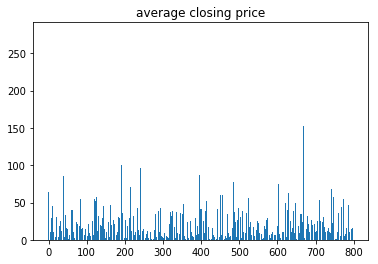

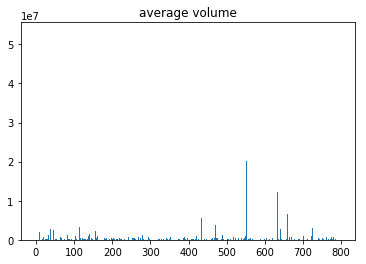

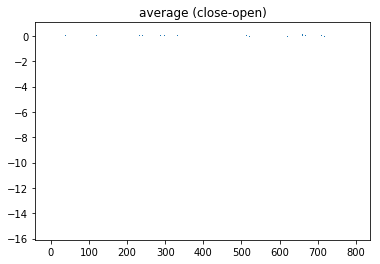

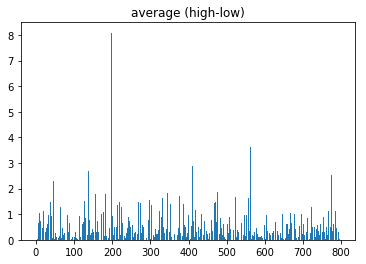

In [10]:
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.bar(range(len(avg_closing.keys())), list(avg_closing.values()))
plt.title('average closing price')
plt.show()

plt.bar(range(len(avg_volume.keys())), list(avg_volume.values()))
plt.title('average volume')
plt.show()

plt.bar(range(len(avg_diff_clos_open.keys())), list(avg_diff_clos_open.values()))
plt.title('average (close-open)')
plt.show()

plt.bar(range(len(avg_dff_high_low.keys())), list(avg_dff_high_low.values()))
plt.title('average (high-low)')
plt.show()

We can clearly see that there are some stocks have remarkably high value. Let's sort these out.

In [11]:
import operator

# sort
avg_closing = sorted(avg_closing.items(), key=operator.itemgetter(1))
avg_volume = sorted(avg_volume.items(), key=operator.itemgetter(1))
avg_diff_clos_open = sorted(avg_diff_clos_open.items(), key=operator.itemgetter(1))
avg_dff_high_low = sorted(avg_dff_high_low.items(), key=operator.itemgetter(1))

In [12]:
print('highest average closing price')
print(avg_closing[-3:])
print()
print('highest average volume')
print(avg_volume[-3:])
print()
print('highest average difference during a day')
print(avg_diff_clos_open[-3:])
print()
print('highest average fluctiation')
print(avg_dff_high_low[-3:])

highest average closing price
[('atri', 176.2088979973879), ('amzn', 228.05109270787983), ('isrg', 277.64649620450996)]

highest average volume
[('aapl', 22702604.50413583), ('intc', 50736044.033086635), ('adxs', 52993282.611580595)]

highest average difference during a day
[('bgne', 0.189010401459854), ('atri', 0.24201832825424446), ('glibp', 0.29526315789473756)]

highest average fluctiation
[('amzn', 5.260663735306923), ('isrg', 6.695976400982363), ('icpt', 8.085273966642495)]


<a id='3'></a>
## 3. The 3 most traded stock for each day
I'll create a data structure that stores dates & stock symbols that were most traded on that day to see what company is hot.

In [13]:
def get_most_traded():
    trades = {}
    for symbol, values in prices_columnwise.items():
        for i, date in enumerate(values['timestamp']):
            if date not in trades:
                trades[date] = []
            trades[date].append([symbol, values['volume'][i]])
    most_traded = []
    for k, v in trades.items():
        ordered = sorted(v, key=lambda x:x[1])
        most_traded.append([k, ordered[-1][0], ordered[-2][0], ordered[-3][0]])
    return most_traded

In [14]:
most_traded = get_most_traded()

In [15]:
# 10 most traded stocks on each day 
most_traded[:10]

[[datetime.datetime(2018, 4, 6, 0, 0), 'aapl', 'intc', 'incy'],
 [datetime.datetime(2018, 4, 5, 0, 0), 'czr', 'aapl', 'intc'],
 [datetime.datetime(2018, 4, 4, 0, 0), 'aapl', 'intc', 'czr'],
 [datetime.datetime(2018, 4, 3, 0, 0), 'intc', 'aapl', 'aker'],
 [datetime.datetime(2018, 4, 2, 0, 0), 'intc', 'aapl', 'amat'],
 [datetime.datetime(2018, 3, 29, 0, 0), 'intc', 'aapl', 'acxm'],
 [datetime.datetime(2018, 3, 28, 0, 0), 'aapl', 'intc', 'gern'],
 [datetime.datetime(2018, 3, 27, 0, 0), 'aapl', 'intc', 'amat'],
 [datetime.datetime(2018, 3, 26, 0, 0), 'intc', 'aapl', 'aker'],
 [datetime.datetime(2018, 3, 23, 0, 0), 'dbx', 'aapl', 'intc']]

If the trading volume of a stock is picked really high on a specific date, chances are that is in the middle of falling price period, except Apple and Intel, which are one of the most traded stocks in NASDAQ. On the other hand, we might found a decreasing period with trading volume pick.

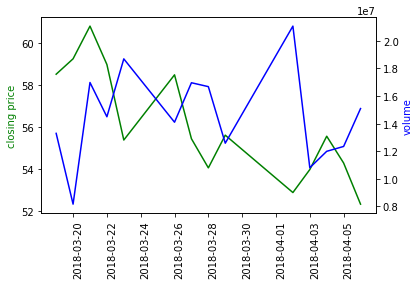

In [16]:
# for example, amat
fig, ax1 = plt.subplots()
ax1.plot(prices_columnwise['amat']['timestamp'][:14], prices_columnwise['amat']['adjusted_close'][:14],'g-')
ax2 = ax1.twinx()
ax2.plot(prices_columnwise['amat']['timestamp'][:14], prices_columnwise['amat']['volume'][:14],'b-')
ax1.set_ylabel('closing price', color='g')
ax2.set_ylabel('volume', color='b')
fig.autofmt_xdate(bottom=0.2, rotation=90, ha='left')
plt.show()

<a id='4'></a>
## 4. Biggest change during after hour
On each day, which one has the most price increase or drecrease during after hour tradings?

In [17]:
def get_biggest_change_afterhour():
    afterhour_change = {}
    biggest_change_afterhour = []
    for symbol, values in prices_columnwise.items():
        length = len(values['timestamp'])
        for i, date in enumerate(values['timestamp']):
            if date not in afterhour_change:
                afterhour_change[date]=[]
            if i < length-1:
                afterhour_change[date].append([symbol, values['open'][i]
                                           -values['adjusted_close'][i+1]])
    for k, v in afterhour_change.items():
        ordered = sorted(v, key=lambda x:x[1], reverse=True)
        if ordered:
            biggest_change_afterhour.append([k, ordered[0], ordered[-1]])
    return biggest_change_afterhour

In [18]:
biggest_change_afterhour = get_biggest_change_afterhour()

In [19]:
# biggest changes in the both directions
biggest_change_afterhour[:10]

[[datetime.datetime(2018, 4, 6, 0, 0),
  ['emcf', 1.25],
  ['amzn', -21.779999999999973]],
 [datetime.datetime(2018, 4, 5, 0, 0),
  ['amzn', 31.420000000000073],
  ['conn', -5.200000000000003]],
 [datetime.datetime(2018, 4, 4, 0, 0),
  ['gfncp', 1.4468999999999994],
  ['amzn', -33.809999999999945]],
 [datetime.datetime(2018, 4, 3, 0, 0),
  ['amzn', 19.3900000000001],
  ['isca', -2.6000000000000014]],
 [datetime.datetime(2018, 4, 2, 0, 0),
  ['cvlt', 5.699999999999996],
  ['amzn', -29.720000000000027]],
 [datetime.datetime(2018, 3, 29, 0, 0),
  ['ggal', 3.6000000000000085],
  ['amzn', -25.420000000000073]],
 [datetime.datetime(2018, 3, 28, 0, 0),
  ['atri', 4.850000000000023],
  ['amzn', -50.049999999999955]],
 [datetime.datetime(2018, 3, 27, 0, 0),
  ['amzn', 16.54000000000019],
  ['isrl', -4.099999999999994]],
 [datetime.datetime(2018, 3, 26, 0, 0),
  ['amzn', 34.440000000000055],
  ['cizn', -0.8499999999999979]],
 [datetime.datetime(2018, 3, 23, 0, 0),
  ['ctas', 3.619999999999976],


This shows the biggest increase/decrease during a after hours trading. In recent 10 days, Amazon is either huge increase or decrease. It's interesting to see this pattern because its stock value has been dropping like a rock after President Trump continued to his tweet tirade against Amazon. 

In [20]:
amzn_open = prices_columnwise['amzn']['open'][:30]
amzn_close = prices_columnwise['amzn']['adjusted_close'][1:31]
timestamp = prices_columnwise['amzn']['timestamp'][:30]

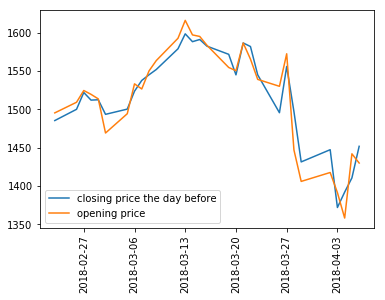

In [21]:
import matplotlib.pyplot as plt 
plt.plot(timestamp, amzn_close, label="closing price the day before")
plt.plot(timestamp, amzn_open, label="opening price")
plt.legend()
plt.xticks(rotation=90)
plt.show()

At the end of the March, you can the descrepancy between prices. It seems like more after hours selling occurred after massive drop down, which resulted in the big gap between opening price and closeing price the day before.